# Train on two sites and test on one

- Train on Acomb+Huby data, then test on Elvington
- Output: Excel files with predicted results, confidence probabilities

In [43]:
import glob
import pathlib
import pandas as pd
import nltk
import spacy
import dimension
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import SCORERS
from sklearn.model_selection import cross_validate
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from collections import OrderedDict
from sklearn.metrics import accuracy_score
import re
import string

# 1. Functions

In [44]:
def clean_text(text):
    """
    Takes text and cleans
    
    :param str text: Text
    :return: Cleaned text
    """
    # text_nonum = re.sub(r'\d+', '', text)  # remove numbers
    text_nonum = " ".join(s for s in text.split() if not any(c.isdigit() for c in s))  # remove words with any digits
    text_split_upper = re.sub(r'((?<=[a-z])[A-Z]|(?<!\A)[A-Z](?=[a-z]))', r' \1', text_nonum)  # use regex to separate words with spaces then split
    text_nopunct = "".join([char.lower() for char in text_split_upper if char not in string.punctuation])  # remove punctuation and convert character to lower case
    text_no_doublespace = re.sub("\s+", " ", text_nopunct).strip()  # substitue multiple whitespace for single. Remove leading and trailing whitespace
    text_no_single = " ".join([w for w in text_no_doublespace.split() if len(w)>2])
    return text_no_single


def preprocess(label_df, scada_df):
    """
    Preprocesses data ready for vectorization
    
    :param label_df: Labelled dataframe
    :param scada_df: Dataframe from scada
    :return: Processed dataframe
    """
    # Prepare dictionary matching description and egu to tag
    desc_dict = scada_df.set_index('TAG').to_dict()['DESCRIPTION']
    egu_dict = scada_df.set_index('TAG').to_dict()['EGU TAG']

    target_labels = ['tag_category', 'tag_subcategory', 'functional_area', 'process_area']

    df = label_df.copy()
    df['description'] = df['scada_tag'].apply(lambda x: desc_dict.get(x))  # map description
    df['egu'] = df['scada_tag'].apply(lambda x: egu_dict.get(x))  # map egu

    # clean features
    df.loc[:, ['sc_tag']] = df['scada_tag'].str.replace('_', ' ')
    df.loc[:, ['sc_tag']] = df['sc_tag'].fillna(' ')
    df.loc[:, ['desc']] = df['description'].str.replace("_", " ")
    df.loc[:, ['desc']] = df['desc'].fillna(' ')
    df.loc[:, ['egu']] = df['egu'].fillna(' ')

    # clean labels
    for label in target_labels:
        df.loc[:, [label]] = df[label].str.strip().replace(" ", "").str.title()

    # combine description features
    df.loc[:, ['clean_desc']] = df['sc_tag'] + ' ' + df['desc'] + ' ' + df['egu'].astype(str)
    df.loc[:, ['clean_desc']] = df['clean_desc'].str.strip()
    df = df[['scada_tag', 'description', 'egu', 'clean_desc', 'site_name', 'tag_category', 'tag_subcategory', 'functional_area', 'process_area']]

    # Fix label inconsistencies between sites
    df = df.replace({'1-Raw Water': '1-Raw Water Intake'})
    df = df.replace({'Rapid Gravity Filters': 'Rapid Gravity Filtration'})

    df['clean_desc'] = df['clean_desc'].str.replace("RGF", " RGF ")
    df['clean_desc'] = df['clean_desc'].str.replace("GAC", " GAC ")
    df['clean_desc'] = df['clean_desc'].apply(lambda x: clean_text(x))
    df['clean_desc'] = df['clean_desc'].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' ')  # remove repeated
    
    ### these did not improve accuracy
    # df['clean_desc'] = df['clean_desc'].str.replace("rgf", "rapid gravity filter")
    # df['clean_desc'] = df['clean_desc'].str.replace("gac", "granular activated carbon")
    # df['clean_desc'] = df['clean_desc'].str.replace("daf", "dissolved air flotation")
    
    df = df[~df['site_name'].str.contains('0')]
    df = df.dropna(subset=target_labels)
    df = df.sort_values(by='site_name')
    df = df.reset_index(drop=True)
    return df


def run_vec(df):
    """
    Runs vectorization to generate word vectors
    
    :param df: Input dataframe
    :return: Dataframe with vector features concatanated
    """
    # no need to use idf since the text is already pretty sparse
    # sublinear tf scaling addresses the problem that 20 occurencs of a word is probably not 20 times more important than 1 occurence
    tfidf = TfidfVectorizer(use_idf=False)
    features = tfidf.fit_transform(df['clean_desc']).toarray()
    df = pd.concat([df, pd.DataFrame(features)], axis=1)
    return df


def generate_pred(X_train, y_train, X_test):
    """
    Generate predictions and probabilities using model
    
    :param X_train: Training features
    :param y_train: Training labels
    :param X_test: Testing features
    """
    model = RandomForestClassifier(n_estimators = 200, random_state=0)
    # svm = LinearSVC(random_state=0)
    # model = CalibratedClassifierCV(svm)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    return y_pred, y_proba


def generate_confusion(y_test, y_pred, annot_list, annot):
    """
    Generate confusion matrix and classification report
    
    :param y_test: Actual testing results
    :param y_pred: Predicted testing results
    :param annot_list: List of factorized target labels
    :param annot: True or false to show annotations on confusion matrix
    :return: Confusion matrix, classification report
    """
    conf_mat = confusion_matrix(y_test, y_pred)
    annotations = pd.DataFrame(conf_mat).astype(str).replace('0', '')

    fig, ax = plt.subplots(figsize=(15,12))
    if annot==True:
        sns.heatmap(conf_mat, annot=annotations, fmt='s', xticklabels=annot_list, yticklabels=annot_list)
    else:
        sns.heatmap(conf_mat, fmt='s')
    plt.ylabel('Actual', fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold')
    plt.title(f'Prediction of {target_label} - Accuracy={int(accuracy_score(y_test, y_pred)*100)}%. Test split={int(100*len(y_test)/(len(y_train)+len(y_test)))}%', fontweight='bold', pad=20)
    plt.show()
    print(metrics.classification_report(y_test, y_pred))
    
    
def mark_all_correct(df):
    """
    Makes a new column with 1 if all labels correct, 0 otherwise
    
    :param df: Result dataframe
    :return: New column with 1 if all correct
    """
    if (df['tag_category_correct']==1) and \
       (df['tag_subcategory_correct']==1) and \
       (df['functional_area_correct']==1) and \
       (df['process_area_correct']==1):
        return 1
    else:
        return 0

# 2. Data Ingestion

In [45]:
## Get Huby scada data
local_path = pathlib.Path(".").resolve()
huby_excel_file = list(local_path.glob("data/YW_tags/WaterProd_HubyTags_Hal24KTrial_V3_AdamNLP.xlsx"))[0].resolve()
huby_scada_df = pd.read_excel(huby_excel_file, sheet_name="Huby-SCADATags", header=0, skiprows=[1])

# Acomb scada data
acomb_excel_file = list(local_path.glob("data/YW_tags/ACOMLDS1_CURRENT.xlsx"))[0].resolve()
acomb_scada_df = pd.read_excel(acomb_excel_file, sheet_name="ACOMLDS1_CURRENT", header=0, skiprows=[1])

# Elvington scada data
elv_excel_file = list(local_path.glob("data/YW_tags/ELVGTNS1_CURRENT.xlsx"))[0].resolve()
elv_scada_df = pd.read_excel(elv_excel_file, sheet_name="ELVGTNS1_CURRENT", header=0, skiprows=[1])

# All 3 sites
all_scada_df = huby_scada_df[['TAG', 'DESCRIPTION']].append(acomb_scada_df[['TAG', 'DESCRIPTION']], ignore_index=True)
all_scada_df = all_scada_df.append(elv_scada_df[['TAG', 'DESCRIPTION', 'EGU TAG']], ignore_index=True)
all_scada_df = all_scada_df.reset_index(drop=True)


# Get labelled data

dim_sdk = dimension.Connect("../../work/config.txt")
db = dim_sdk.db()
site_tags = db['site_tag_config']
cursor = site_tags.find({}, {"_id": 0,
                             "scada_tag": 1,
                             "site_name": 1,
                             "functional_area": 1, 
                             "process_area": 1, 
                             "tag_category": 1, 
                             "tag_subcategory": 1, 
                             "tag_name": 1,  
                             "common_reference": 1,
                             "is_alarm": 1
                             }
                         )
master_tag_data = list(cursor)
master_tag_dict = {tag_details.get("tag_name"): tag_details for tag_details in master_tag_data}
master_tag_df = pd.DataFrame(master_tag_data)
# site_tags.find_one()

# Labelled target data
huby_label_df = master_tag_df[master_tag_df['site_name']=='HUBY'].reset_index(drop=True)
acomb_label_df = master_tag_df[master_tag_df['site_name']=='ACOMB'].reset_index(drop=True)
elv_label_df = master_tag_df[master_tag_df['site_name']=='ELVINGTON'].reset_index(drop=True)
all_label_df = master_tag_df

Connecting to database.
Connection successful.


# Train on Acomb+Huby, test on Elvington

In [46]:
####### PREPROCESSING AND FEATURE GENERATION #######

df_all_proc = preprocess(all_label_df, all_scada_df)  # preprocess all data
df_all = run_vec(df_all_proc)  # vectorize text. Labels categored here again.
# df_all = df_all[~df_all['functional_area'].isin(['Tbd', 'Multiflo', '9-Clean Water Distribution', 'Raw Water Sampling', 'Actiflow Clarification'])]
df_all = df_all.reset_index(drop=True)

df_a = df_all[df_all['site_name']=='ACOMB']
df_e = df_all[df_all['site_name']=='ELVINGTON']
df_h = df_all[df_all['site_name']=='HUBY']
df_ah = pd.concat([df_a, df_h])

# Factorize at this level, since we can only predict what we've seen in the training data.
df_ah['tag_cat_id'] = df_ah['tag_category'].factorize()[0]
df_ah['tag_subcat_id'] = df_ah['tag_subcategory'].factorize()[0]
df_ah['func_area_id'] = df_ah['functional_area'].factorize()[0]
df_ah['proc_area_id'] = df_ah['process_area'].factorize()[0]

feat_drop_cols = ['scada_tag','description','egu','clean_desc','site_name','tag_category','tag_subcategory', 'functional_area', 'process_area', 'tag_cat_id','tag_subcat_id','func_area_id','proc_area_id']
df_ah_feat = df_ah.drop(feat_drop_cols, axis=1)
df_e_feat = df_e.drop(['scada_tag','description','egu','clean_desc','site_name','tag_category','tag_subcategory', 'functional_area', 'process_area'], axis=1)

df_ah_lab_tag_cat = df_ah['tag_cat_id']
df_ah_lab_tag_subcat = df_ah['tag_subcat_id']
df_ah_lab_func_area = df_ah['func_area_id']
df_ah_lab_proc_area = df_ah['proc_area_id']

In [47]:
final_res = pd.DataFrame()
##### INPUTS ######
target_label = 'tag_category'
target_label_no = 'tag_cat_id'
y_train = df_ah_lab_tag_cat

######## MODEL TRAINING #######
X_train = df_ah_feat
X_test = df_e_feat
y_test = df_e[target_label]

y_pred, y_proba = generate_pred(X_train, y_train, X_test)

##### RESULTS ANALYSIS #####
proba_df = pd.DataFrame(y_proba)
res = pd.DataFrame(y_test)
res['copy_index']=res.index  # save index
res = res.reset_index(drop=True)  # reset index for merging
res = pd.concat([res, pd.DataFrame(y_pred)], axis=1)  # merge predictions
res = pd.concat([res, proba_df], axis=1)  # merge probabilities
res = res.set_index('copy_index')  # re-instate index

tag_cat_labels = df_ah[target_label].drop_duplicates().tolist()  # names of tag labels
res.columns = ['y_test', 'y_pred'] + tag_cat_labels  # rename columns
res['max_proba'] = res[tag_cat_labels].max(axis=1)  # add column with maximum probability

tag_dict = dict(zip(df_ah[target_label_no].drop_duplicates(), df_ah[target_label].drop_duplicates()))  # dictionary of labels
res['actual'] = res['y_test']
res['predicted'] = res['y_pred'].map(tag_dict)
res['correct'] = np.where(res['actual'] == res['predicted'], 1, 0)  # add column checking if correct

add_res = res[['actual', 'predicted', 'correct', 'max_proba']]
add_res.columns = [f'{target_label}_actual', f'{target_label}_predicted', f'{target_label}_correct', f'{target_label}_max_proba']
final_res = pd.concat([final_res, add_res], axis=1, sort=False)

In [48]:
#### INPUTS ######
target_label = 'tag_subcategory'
target_label_no = 'tag_subcat_id'
y_train = df_ah_lab_tag_subcat

######## MODEL TRAINING #######
X_train = df_ah_feat
X_test = df_e_feat
y_test = df_e[target_label]

y_pred, y_proba = generate_pred(X_train, y_train, X_test)

##### RESULTS ANALYSIS #####
proba_df = pd.DataFrame(y_proba)
res = pd.DataFrame(y_test)
res['copy_index']=res.index  # save index
res = res.reset_index(drop=True)  # reset index for merging
res = pd.concat([res, pd.DataFrame(y_pred)], axis=1)  # merge predictions
res = pd.concat([res, proba_df], axis=1)  # merge probabilities
res = res.set_index('copy_index')  # re-instate index

tag_cat_labels = df_ah[target_label].drop_duplicates().tolist()  # names of tag labels
res.columns = ['y_test', 'y_pred'] + tag_cat_labels  # rename columns
res['max_proba'] = res[tag_cat_labels].max(axis=1)  # add column with maximum probability

tag_dict = dict(zip(df_ah[target_label_no].drop_duplicates(), df_ah[target_label].drop_duplicates()))  # dictionary of labels
res['actual'] = res['y_test']
res['predicted'] = res['y_pred'].map(tag_dict)
res['correct'] = np.where(res['actual'] == res['predicted'], 1, 0)  # add column checking if correct

add_res = res[['actual', 'predicted', 'correct', 'max_proba']]
add_res.columns = [f'{target_label}_actual', f'{target_label}_predicted', f'{target_label}_correct', f'{target_label}_max_proba']
final_res = pd.concat([final_res, add_res], axis=1, sort=False)

In [49]:
#### INPUTS ######
target_label = 'functional_area'
target_label_no = 'func_area_id'
y_train = df_ah_lab_func_area

######## MODEL TRAINING #######

X_train = df_ah_feat
X_test = df_e_feat
y_test = df_e[target_label]

y_pred, y_proba = generate_pred(X_train, y_train, X_test)

##### RESULTS ANALYSIS #####
proba_df = pd.DataFrame(y_proba)
res = pd.DataFrame(y_test)
res['copy_index']=res.index  # save index
res = res.reset_index(drop=True)  # reset index for merging
res = pd.concat([res, pd.DataFrame(y_pred)], axis=1)  # merge predictions
res = pd.concat([res, proba_df], axis=1)  # merge probabilities
res = res.set_index('copy_index')  # re-instate index

tag_cat_labels = df_ah[target_label].drop_duplicates().tolist()  # names of tag labels
res.columns = ['y_test', 'y_pred'] + tag_cat_labels  # rename columns
res['max_proba'] = res[tag_cat_labels].max(axis=1)  # add column with maximum probability

tag_dict = dict(zip(df_ah[target_label_no].drop_duplicates(), df_ah[target_label].drop_duplicates()))  # dictionary of labels
res['actual'] = res['y_test']
res['predicted'] = res['y_pred'].map(tag_dict)
res['correct'] = np.where(res['actual'] == res['predicted'], 1, 0)  # add column checking if correct

add_res = res[['actual', 'predicted', 'correct', 'max_proba']]
add_res.columns = [f'{target_label}_actual', f'{target_label}_predicted', f'{target_label}_correct', f'{target_label}_max_proba']
final_res = pd.concat([final_res, add_res], axis=1, sort=False)

In [50]:
##### INPUTS ######
target_label = 'process_area'
target_label_no = 'proc_area_id'
y_train = df_ah_lab_proc_area

######## MODEL TRAINING #######

X_train = df_ah_feat
X_test = df_e_feat
y_test = df_e[target_label]

y_pred, y_proba = generate_pred(X_train, y_train, X_test)

##### RESULTS ANALYSIS #####
proba_df = pd.DataFrame(y_proba)
res = pd.DataFrame(y_test)
res['copy_index']=res.index  # save index
res = res.reset_index(drop=True)  # reset index for merging
res = pd.concat([res, pd.DataFrame(y_pred)], axis=1)  # merge predictions
res = pd.concat([res, proba_df], axis=1)  # merge probabilities
res = res.set_index('copy_index')  # re-instate index

tag_cat_labels = df_ah[target_label].drop_duplicates().tolist()  # names of tag labels
res.columns = ['y_test', 'y_pred'] + tag_cat_labels  # rename columns
res['max_proba'] = res[tag_cat_labels].max(axis=1)  # add column with maximum probability

tag_dict = dict(zip(df_ah[target_label_no].drop_duplicates(), df_ah[target_label].drop_duplicates()))  # dictionary of labels
res['actual'] = res['y_test']
res['predicted'] = res['y_pred'].map(tag_dict)
res['correct'] = np.where(res['actual'] == res['predicted'], 1, 0)  # add column checking if correct

add_res = res[['actual', 'predicted', 'correct', 'max_proba']]
add_res.columns = [f'{target_label}_actual', f'{target_label}_predicted', f'{target_label}_correct', f'{target_label}_max_proba']
final_res = pd.concat([final_res, add_res], axis=1, sort=False)

In [51]:
##### FINAL DATAFRAME PREPARATION #####

final_df = pd.DataFrame(columns=('scada_tag','description','egu', 'clean_desc'))
final_df = pd.concat([final_df, final_res])

scada_dict = dict(zip(df_e.index, df_e['scada_tag']))
desc_dict = dict(zip(df_e.index, df_e['description']))
egu_dict = dict(zip(df_e.index, df_e['egu']))
clean_desc_dict = dict(zip(df_e.index, df_e['clean_desc']))

final_df['scada_tag'] = final_res.index.map(scada_dict)
final_df['description'] = final_res.index.map(desc_dict)
final_df['egu'] = final_res.index.map(egu_dict)
final_df['clean_desc'] = final_res.index.map(clean_desc_dict)

final_df['all_correct'] = final_df.apply(mark_all_correct, axis=1)
final_df['all_proba'] = final_df['tag_category_max_proba'] * final_df['tag_subcategory_max_proba'] * final_df['functional_area_max_proba'] * final_df['process_area_max_proba']

tag_cat_accuracy = int(100*final_df['tag_category_correct'].value_counts()[1] / len(final_df))
tag_subcat_accuracy = int(100*final_df['tag_subcategory_correct'].value_counts()[1] / len(final_df))
func_area_accuracy = int(100*final_df['functional_area_correct'].value_counts()[1] / len(final_df))
proc_area_accuracy = int(100*final_df['process_area_correct'].value_counts()[1] / len(final_df))
all_accuracy = int(100*final_df['all_correct'].value_counts()[1] / len(final_df))

print(f"Tag category accuracy: {tag_cat_accuracy}%")
print(f"Tag subcategory accuracy: {tag_subcat_accuracy}%")
print(f"Functional area accuracy: {func_area_accuracy}%")
print(f"Process area accuracy: {proc_area_accuracy}%")
print(f"Full row accuracy: {all_accuracy}%")

Tag category accuracy: 77%
Tag subcategory accuracy: 28%
Functional area accuracy: 44%
Process area accuracy: 30%
Full row accuracy: 7%


In [52]:
only_elv_tag_cat = set(final_df['tag_category_actual'])-set(df_ah['tag_category'])
final_df['tag_category_exists'] = np.where(final_df['tag_category_actual'].isin(only_elv_tag_cat), 0, 1)
                                              
sum(final_df[final_df['tag_category_exists']==1]['tag_category_correct']==1) / len(final_df[final_df['tag_category_exists']==1])

0.7782782782782782

In [53]:
only_elv_tag_subcat = set(final_df['tag_subcategory_actual'])-set(df_ah['tag_subcategory'])
final_df['tag_subcategory_exists'] = np.where(final_df['tag_subcategory_actual'].isin(only_elv_tag_subcat), 0, 1)
                                              
sum(final_df[final_df['tag_subcategory_exists']==1]['tag_subcategory_correct']==1) / len(final_df[final_df['tag_subcategory_exists']==1])

0.3858108108108108

In [54]:
only_elv_func_area = set(final_df['functional_area_actual'])-set(df_ah['functional_area'])
final_df['functional_area_exists'] = np.where(final_df['functional_area_actual'].isin(only_elv_func_area), 0, 1)
                                              
sum(final_df[final_df['functional_area_exists']==1]['functional_area_correct']==1) / len(final_df[final_df['functional_area_exists']==1])

0.5149253731343284

In [55]:
only_elv_proc_area = set(final_df['process_area_actual'])-set(df_ah['process_area'])
final_df['process_area_exists'] = np.where(final_df['process_area_actual'].isin(only_elv_proc_area), 0, 1)
                                              
sum(final_df[final_df['process_area_exists']==1]['process_area_correct']==1) / len(final_df[final_df['process_area_exists']==1])

0.6168032786885246

In [56]:
only_elv_all_labels_df = final_df[(final_df.loc[:, ['tag_category_exists', 'tag_subcategory_exists', 'functional_area_exists', 'process_area_exists']]==1).all(axis=1)]
sum(only_elv_all_labels_df['all_correct']==1) / len(only_elv_all_labels_df)

0.21194029850746268

In [57]:
# final_df.to_csv('ha_train_elv_test_results.csv')

# Plotted probabilities

Text(0.5, 1.0, 'Tag category not correct (n=443)')

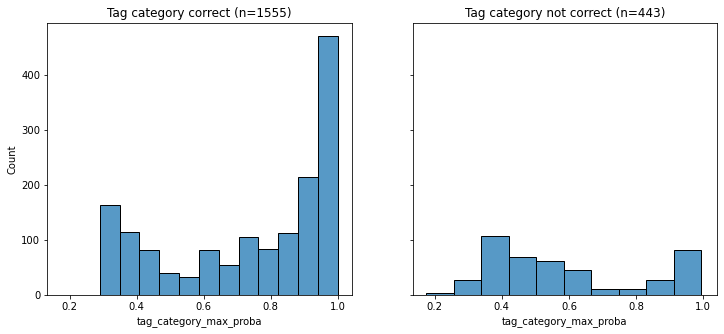

In [58]:
label='tag_category_correct'
proba='tag_category_max_proba'

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)
sns.histplot(final_df[final_df[label]==1][proba], ax=axes[0])
sns.histplot(final_df[final_df[label]!=1][proba], ax=axes[1])

axes[0].set_title(f"Tag category correct (n={sum(final_df[label]==1)})")
axes[1].set_title(f"Tag category not correct (n={sum(final_df[label]!=1)})")

Text(0.5, 1.0, 'Incorrect predictions')

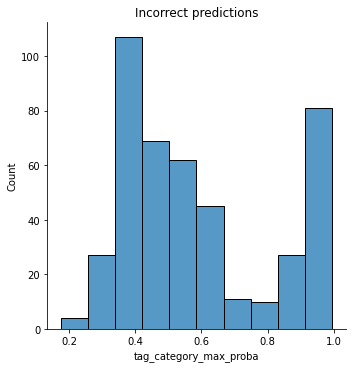

In [59]:
sns.displot(final_df[final_df['tag_category_correct']!=1]['tag_category_max_proba'])
plt.title('Incorrect predictions')

# Graphs showing correct and incorrect prediction distribution

In [60]:
"""
df_ah[['scada_tag',
 'description',
 'egu',
 'clean_desc',
 'site_name',
 'tag_category',
 'tag_subcategory',
 'functional_area',
 'process_area',]].to_csv('acomb+huby_training_data.csv')
"""

"\ndf_ah[['scada_tag',\n 'description',\n 'egu',\n 'clean_desc',\n 'site_name',\n 'tag_category',\n 'tag_subcategory',\n 'functional_area',\n 'process_area',]].to_csv('acomb+huby_training_data.csv')\n"

In [61]:
tag_act = final_df.loc[:, ['tag_category_actual']]
tag_act['class'] = 'actual'
tag_act.columns=('tag_category', 'class')

# predicted tags, if they were correct
tag_correct_df = final_df[final_df['tag_category_correct']==1]
tag_pred = tag_correct_df.loc[:, ['tag_category_predicted']]
tag_pred['class'] = 'predicted (correct)'
tag_pred.columns=('tag_category', 'class')

tag_incorrect_df = final_df[final_df['tag_category_correct']==0]
tag_pred_inc = tag_incorrect_df.loc[:, ['tag_category_predicted']]
tag_pred_inc['class'] = 'predicted (incorrect)'
tag_pred_inc.columns=('tag_category', 'class')

tag = tag_act.append(tag_pred, ignore_index=True)
tag = tag.append(tag_pred_inc, ignore_index=True)
tag = tag.sort_values(by='class')

plt.figure(figsize=(20,6))
sns.countplot(x='tag_category', hue='class', data=tag)
tag_possible = len(tag_act['tag_category'].value_counts())
plt.title(f'Elvington test set. Accuracy = {tag_cat_accuracy}%. {tag_possible} possible classes. Test n={len(tag_act)}')
plt.legend(loc="upper right" )
plt.show()

In [62]:
tag_act = final_df.loc[:, ['tag_subcategory_actual']]
tag_act['class'] = 'actual'
tag_act.columns=('tag_subcategory', 'class')

# predicted tags, if they were correct
tag_correct_df = final_df[final_df['tag_subcategory_correct']==1]
tag_pred = tag_correct_df.loc[:, ['tag_subcategory_predicted']]
tag_pred['class'] = 'predicted (correct)'
tag_pred.columns=('tag_subcategory', 'class')

tag_incorrect_df = final_df[final_df['tag_subcategory_correct']==0]
tag_pred_inc = tag_incorrect_df.loc[:, ['tag_subcategory_predicted']]
tag_pred_inc['class'] = 'predicted (incorrect)'
tag_pred_inc.columns=('tag_subcategory', 'class')

tag = tag_act.append(tag_pred, ignore_index=True)
tag = tag.append(tag_pred_inc, ignore_index=True)
tag = tag.sort_values(by='class')

plt.figure(figsize=(20,6))
sns.countplot(x='tag_subcategory', hue='class', data=tag)
tag_possible = len(tag_act['tag_subcategory'].value_counts())
plt.title(f'Elvington test set. Accuracy = {tag_subcat_accuracy}%. {tag_possible} possible classes. Test n={len(tag_act)}')
plt.legend(loc="upper right")
plt.xticks([])
plt.show()

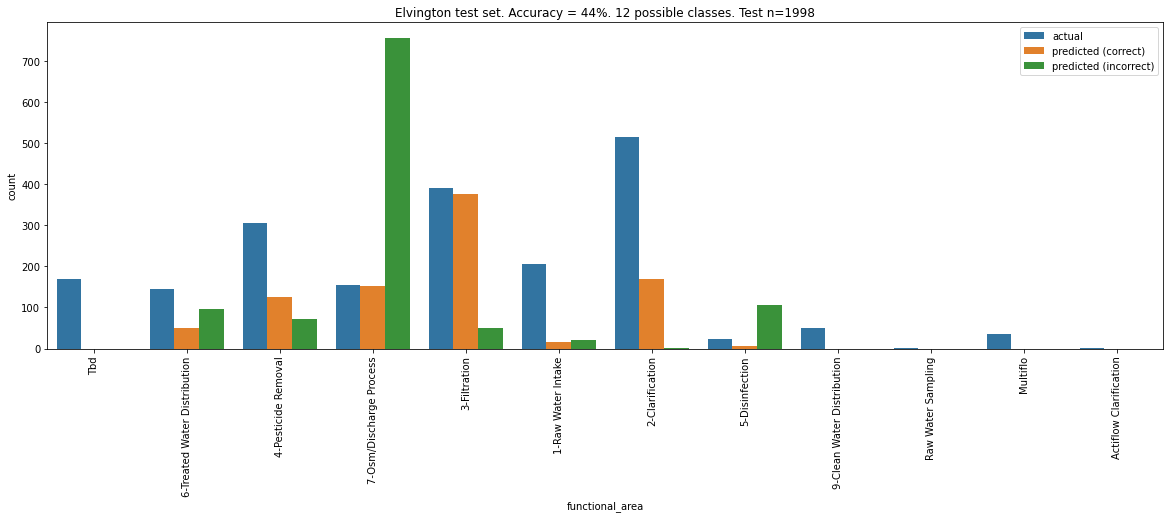

In [63]:
tag_act = final_df.loc[:, ['functional_area_actual']]
tag_act['class'] = 'actual'
tag_act.columns=('functional_area', 'class')

# predicted tags, if they were correct
tag_correct_df = final_df[final_df['functional_area_correct']==1]
tag_pred = tag_correct_df.loc[:, ['functional_area_predicted']]
tag_pred['class'] = 'predicted (correct)'
tag_pred.columns=('functional_area', 'class')

tag_incorrect_df = final_df[final_df['functional_area_correct']==0]
tag_pred_inc = tag_incorrect_df.loc[:, ['functional_area_predicted']]
tag_pred_inc['class'] = 'predicted (incorrect)'
tag_pred_inc.columns=('functional_area', 'class')

tag = tag_act.append(tag_pred, ignore_index=True)
tag = tag.append(tag_pred_inc, ignore_index=True)
tag = tag.sort_values(by='class')

plt.figure(figsize=(20,6))
sns.countplot(x='functional_area', hue='class', data=tag)
tag_possible = len(tag_act['functional_area'].value_counts())
plt.title(f'Elvington test set. Accuracy = {func_area_accuracy}%. {tag_possible} possible classes. Test n={len(tag_act)}')
plt.legend(loc="upper right")
plt.xticks(rotation=90)
plt.show()

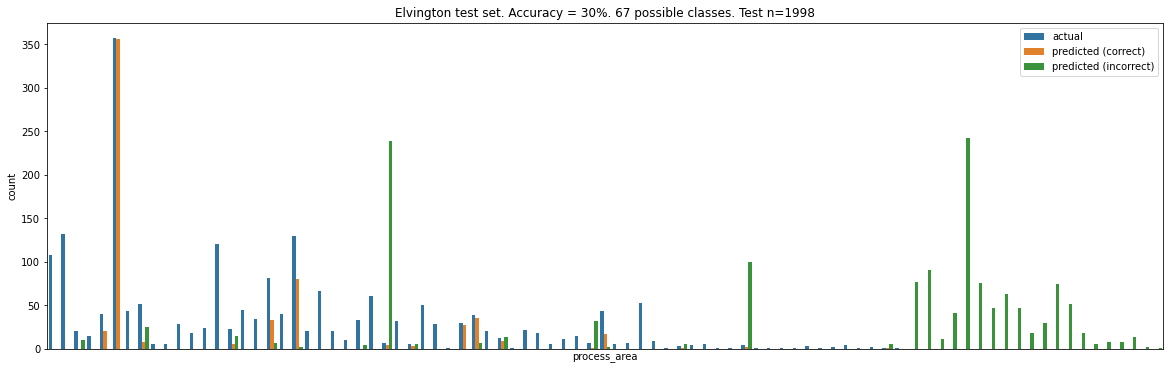

In [64]:
tag_act = final_df.loc[:, ['process_area_actual']]
tag_act['class'] = 'actual'
tag_act.columns=('process_area', 'class')

# predicted tags, if they were correct
tag_correct_df = final_df[final_df['process_area_correct']==1]
tag_pred = tag_correct_df.loc[:, ['process_area_predicted']]
tag_pred['class'] = 'predicted (correct)'
tag_pred.columns=('process_area', 'class')

tag_incorrect_df = final_df[final_df['process_area_correct']==0]
tag_pred_inc = tag_incorrect_df.loc[:, ['process_area_predicted']]
tag_pred_inc['class'] = 'predicted (incorrect)'
tag_pred_inc.columns=('process_area', 'class')

tag = tag_act.append(tag_pred, ignore_index=True)
tag = tag.append(tag_pred_inc, ignore_index=True)
tag = tag.sort_values(by='class')

plt.figure(figsize=(20,6))
sns.countplot(x='process_area', hue='class', data=tag)
tag_possible = len(tag_act['process_area'].value_counts())
plt.title(f'Elvington test set. Accuracy = {proc_area_accuracy}%. {tag_possible} possible classes. Test n={len(tag_act)}')
plt.legend(loc="upper right")
plt.xticks([])
plt.show()